In [1]:
# Window Size and Stride Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# 1. Load and prepare the data
def load_data(file_path: str) -> pd.DataFrame:
    """Load data from CSV file."""
    df = pd.read_csv(file_path)
    print("Data shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    return df

In [2]:
# Initialize settings
file_path = r"C:\Users\Emanuele\Documents\ProgettiPython\DL_approach_handwriting\data\raw\aggregated_data.csv"
df = load_data(file_path)

Data shape: (114619, 37)

Columns: ['Id', 'Segment', 'StartTime', 'Duration', 'StartVerticalPosition', 'VerticalSize', 'PeakVerticalVelocity', 'PeakVerticalAcceleration', 'StartHorizontalPosition', 'HorizontalSize', 'StraightnessError', 'Slant', 'LoopSurface', 'RelativeInitialSlant', 'RelativeTimeToPeakVerticalVelocity', 'RelativePenDownDuration', 'RelativeDurationofPrimary', 'RelativeSizeofPrimary', 'FrequencyofSecondary', 'AbsoluteSize', 'AverageAbsoluteVelocity', 'Roadlength', 'AbsoluteyJerk', 'NormalizedyJerk', 'AverageNormalizedyJerkPerTrial', 'AbsoluteJerk', 'NormalizedJerk', 'AverageNormalizedJerkPerTrial', 'NumberOfPeakAccelerationPoints', 'AveragePenPressure', 'NumOfStrokes', 'Sex', 'Age', 'Work', 'Education', 'Label', 'Task_ID']


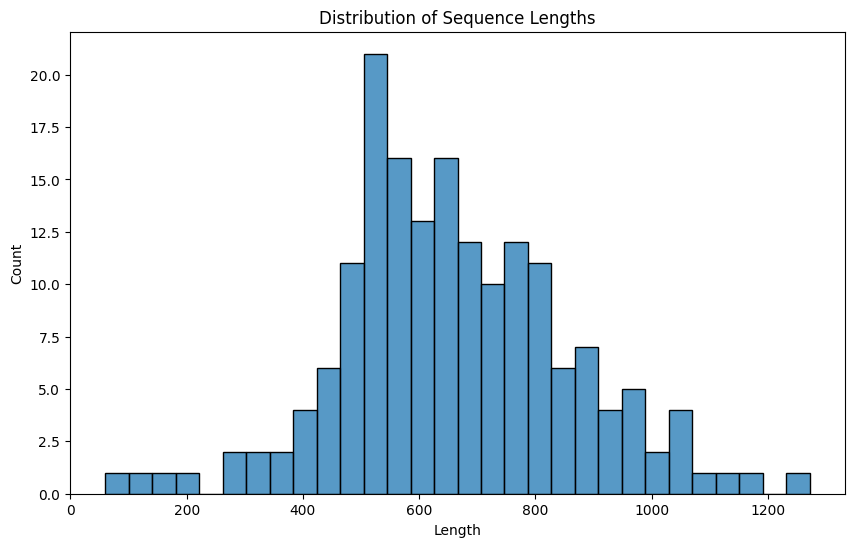


Sequence Statistics:
min_length: 60.00
max_length: 1272.00
mean_length: 658.73
median_length: 642.50
std_length: 199.06

Percentiles:
25th: 528.00
75th: 781.25


In [3]:
# 2. Analyze sequence lengths
def analyze_sequences(df: pd.DataFrame, id_column: str) -> Dict:
    """Analyze sequence lengths and their distribution."""
    sequence_lengths = df.groupby(id_column).size()
    
    stats = {
        'min_length': sequence_lengths.min(),
        'max_length': sequence_lengths.max(),
        'mean_length': sequence_lengths.mean(),
        'median_length': sequence_lengths.median(),
        'std_length': sequence_lengths.std(),
        'percentiles': {
            '25th': sequence_lengths.quantile(0.25),
            '75th': sequence_lengths.quantile(0.75)
        }
    }
    
    # Plot length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(sequence_lengths, bins=30)
    plt.title('Distribution of Sequence Lengths')
    plt.xlabel('Length')
    plt.ylabel('Count')
    plt.show()
    
    return stats

# Analyze sequences
sequence_stats = analyze_sequences(df, 'Id')  
print("\nSequence Statistics:")
for key, value in sequence_stats.items():
    if key != 'percentiles':
        print(f"{key}: {value:.2f}")
    else:
        print("\nPercentiles:")
        for p_key, p_value in value.items():
            print(f"{p_key}: {p_value:.2f}")

In [6]:
# 3. Test different window sizes and strides
def evaluate_window_stride(
    df: pd.DataFrame,
    id_column: str,
    feature_columns: List[str],
    window_size: int,
    stride: int,
    min_segments: int = 3
) -> Dict:
    """Evaluate a specific window size and stride combination."""
    sequence_lengths = df.groupby(id_column).size()
    
    # Calculate segments per sequence
    segments_per_seq = [(length - window_size) // stride + 1 
                       for length in sequence_lengths]
    segments_per_seq = [max(0, seg) for seg in segments_per_seq]
    
    # Calculate coverage
    total_points = sum(sequence_lengths)
    covered_points = sum(min(length, (segs * stride + window_size)) 
                        for length, segs in zip(sequence_lengths, segments_per_seq))
    coverage_ratio = covered_points / total_points
    
    # Calculate sequence coverage
    adequate_sequences = sum(1 for segs in segments_per_seq if segs >= min_segments)
    sequence_coverage = adequate_sequences / len(sequence_lengths)
    
    # Calculate information preservation
    preservation_scores = []
    scaler = StandardScaler()
    
    for _, sequence in df.groupby(id_column):
        if len(sequence) < window_size:
            continue
        
        windows = []
        for start in range(0, len(sequence) - window_size + 1, stride):
            window = sequence[feature_columns].iloc[start:start + window_size]
            windows.append(window.values.flatten())
        
        if len(windows) < 2:
            continue
        
        try:
            windows = np.array(windows)
            windows = scaler.fit_transform(windows)
            score = silhouette_score(windows, np.arange(len(windows)), metric='euclidean')
            preservation_scores.append(score)
        except:
            continue
    
    info_preservation = np.mean(preservation_scores) if preservation_scores else 0.0
    
    return {
        'coverage_ratio': coverage_ratio,
        'sequence_coverage': sequence_coverage,
        'avg_segments': np.mean(segments_per_seq),
        'min_segments': np.min(segments_per_seq),
        'info_preservation': info_preservation
    }


Identified 34 feature columns:
['StartTime', 'Duration', 'StartVerticalPosition', 'VerticalSize', 'PeakVerticalVelocity', 'PeakVerticalAcceleration', 'StartHorizontalPosition', 'HorizontalSize', 'StraightnessError', 'Slant', 'LoopSurface', 'RelativeInitialSlant', 'RelativeTimeToPeakVerticalVelocity', 'RelativePenDownDuration', 'RelativeDurationofPrimary', 'RelativeSizeofPrimary', 'FrequencyofSecondary', 'AbsoluteSize', 'AverageAbsoluteVelocity', 'Roadlength', 'AbsoluteyJerk', 'NormalizedyJerk', 'AverageNormalizedyJerkPerTrial', 'AbsoluteJerk', 'NormalizedJerk', 'AverageNormalizedJerkPerTrial', 'NumberOfPeakAccelerationPoints', 'AveragePenPressure', 'NumOfStrokes', 'Sex', 'Age', 'Work', 'Education', 'Task_ID']
Progress: 145/190
Grid search completed!

Optimal Window Size: 10
Optimal Stride: 5


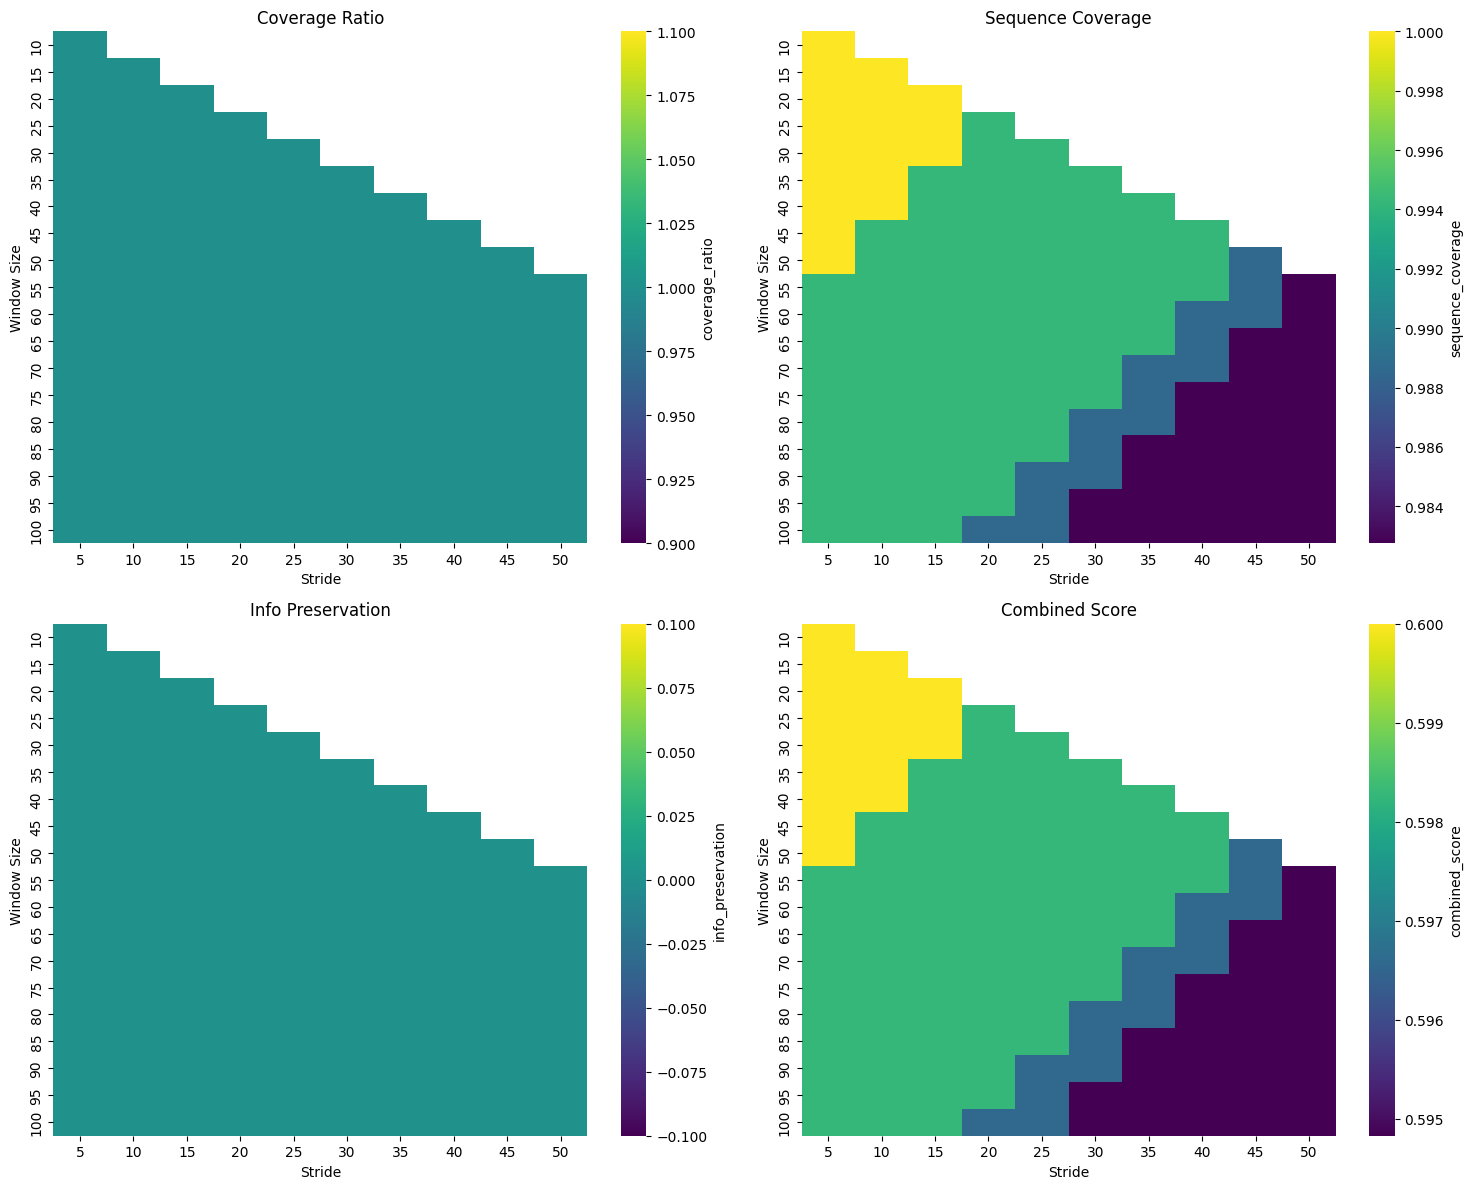


Optimal Parameter Characteristics:
Window Size: 10
Stride: 5
Coverage Ratio: 1.0000
Sequence Coverage: 1.0000
Information Preservation: 0.0000
Average Segments per Sequence: 130.36
Combined Score: 0.6000


In [7]:

# 4. Grid search for optimal parameters
def grid_search_parameters(
    df: pd.DataFrame,
    id_column: str,
    feature_columns: List[str],
    min_window: int = 10,
    max_window: int = 100,
    min_stride: int = 5,
    max_stride: int = 50,
    window_step: int = 5,
    stride_step: int = 5
) -> Tuple[int, int, List[Dict]]:
    """Perform grid search for optimal window size and stride."""
    results = []
    best_score = -float('inf')
    optimal_window = None
    optimal_stride = None
    
    total_iterations = ((max_window - min_window) // window_step + 1) * \
                      ((max_stride - min_stride) // stride_step + 1)
    current_iteration = 0
    
    for window_size in range(min_window, max_window + 1, window_step):
        for stride in range(min_stride, min(window_size, max_stride + 1), stride_step):
            current_iteration += 1
            print(f"\rProgress: {current_iteration}/{total_iterations}", end="")
            
            metrics = evaluate_window_stride(
                df, id_column, feature_columns, 
                window_size, stride
            )
            
            combined_score = (
                metrics['coverage_ratio'] * 0.3 +
                metrics['sequence_coverage'] * 0.3 +
                metrics['info_preservation'] * 0.4
            )
            
            results.append({
                'window_size': window_size,
                'stride': stride,
                'combined_score': combined_score,
                **metrics
            })
            
            if combined_score > best_score:
                best_score = combined_score
                optimal_window = window_size
                optimal_stride = stride
    
    print("\nGrid search completed!")
    return optimal_window, optimal_stride, results

# 5. Visualize results
def plot_parameter_heatmaps(results: List[Dict]) -> None:
    """Plot heatmaps for different metrics."""
    results_df = pd.DataFrame(results)
    
    metrics = [
        'coverage_ratio', 'sequence_coverage', 
        'info_preservation', 'combined_score'
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        pivot_table = results_df.pivot(
            index='window_size', 
            columns='stride', 
            values=metric
        )
        
        sns.heatmap(
            pivot_table, 
            ax=axes[idx],
            cmap='viridis',
            cbar_kws={'label': metric}
        )
        
        axes[idx].set_title(f'{metric.replace("_", " ").title()}')
        axes[idx].set_xlabel('Stride')
        axes[idx].set_ylabel('Window Size')
    
    plt.tight_layout()
    plt.show()

# Run the analysis
# Identify feature columns by excluding metadata columns
def get_feature_columns(df: pd.DataFrame, column_names: Dict[str, str]) -> List[str]:
    """
    Extract feature columns from DataFrame by excluding metadata columns.
    
    Args:
        df: Input DataFrame
        column_names: Dictionary mapping column types to their names
        
    Returns:
        List of feature column names
    """
    # Get metadata columns to exclude
    metadata_cols = [
        column_names[k] for k in ['id', 'segment', 'task', 'label']
        if k in column_names
    ]
    
    # Additional columns to exclude (based on naming patterns)
    exclude_patterns = ['Id', 'Segment', '_label']
    
    # Get feature columns by excluding metadata and pattern-matched columns
    feature_cols = [
        col for col in df.columns 
        if col not in metadata_cols
        and not any(pattern in col for pattern in exclude_patterns)
    ]
    
    print(f"Identified {len(feature_cols)} feature columns:")
    print(feature_cols)
    
    return feature_cols

# Define column names based on your data structure
column_names = {
    'id': 'Id',  # Subject identifier
    'segment': 'Segment',  # Segment identifier
    'task': 'Task',  # Task identifier
    'label': 'Label'  # Target variable
}

# Get feature columns automatically
feature_columns = get_feature_columns(df, column_names)

optimal_window, optimal_stride, results = grid_search_parameters(
    df=df,
    id_column='Id',  # Replace with your ID column
    feature_columns=feature_columns,
    min_window=10,
    max_window=100,
    min_stride=5,
    max_stride=50
)

print(f"\nOptimal Window Size: {optimal_window}")
print(f"Optimal Stride: {optimal_stride}")

# Plot results
plot_parameter_heatmaps(results)

# 6. Analyze optimal parameters
def analyze_optimal_parameters(results: List[Dict], optimal_window: int, optimal_stride: int) -> None:
    """Analyze the characteristics of the optimal parameters."""
    optimal_result = next(
        result for result in results 
        if result['window_size'] == optimal_window and result['stride'] == optimal_stride
    )
    
    print("\nOptimal Parameter Characteristics:")
    print(f"Window Size: {optimal_window}")
    print(f"Stride: {optimal_stride}")
    print(f"Coverage Ratio: {optimal_result['coverage_ratio']:.4f}")
    print(f"Sequence Coverage: {optimal_result['sequence_coverage']:.4f}")
    print(f"Information Preservation: {optimal_result['info_preservation']:.4f}")
    print(f"Average Segments per Sequence: {optimal_result['avg_segments']:.2f}")
    print(f"Combined Score: {optimal_result['combined_score']:.4f}")

# Analyze optimal parameters
analyze_optimal_parameters(results, optimal_window, optimal_stride)

# Model Hyperparameters 

In [9]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler


class CustomLabelEncoder:
    """Custom label encoder to ensure specific mapping for health status."""
    def __init__(self):
        self.classes_ = np.array(['Sano', 'Malato'])  # 'Sano' -> 0, 'Malato' -> 1
        self.mapping_ = {'Sano': 0, 'Malato': 1}
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        return np.array([self.mapping_[val.strip()] for val in y])
    
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)


class HyperparameterOptimizer:
    """Optimize training hyperparameters based on data characteristics."""
    
    def __init__(
        self,
        data: pd.DataFrame,
        feature_columns: List[str],
        column_names: Dict[str, str],
        scaler_type: str = "standard",
        verbose: bool = True
    ):
        """
        Initialize the optimizer using project's preprocessing pipeline.
        
        Args:
            data: Input DataFrame
            feature_columns: List of feature column names
            column_names: Dictionary mapping column types to their names
            scaler_type: Type of scaler to use ("standard" or "robust")
            verbose: Whether to print detailed information
        """
        self.data = data.copy()
        self.column_names = column_names
        self.verbose = verbose
        self.scaler_type = scaler_type.lower()
        
        # Initialize encoders first
        self.encoders = {
            'sex': LabelEncoder(),
            'work': LabelEncoder(),
            'label': CustomLabelEncoder()
        }
        
        # Preprocess the data
        self._preprocess_data()
        
        # Update feature columns to match preprocessed column names
        self.feature_columns = [
            col for col in feature_columns
            if col in self.data.columns  # Only keep columns that still exist
            or col.replace('_encoded', '') in ['Sex', 'Work']  # Include encoded versions of categorical columns
        ]
        
        # Add encoded versions of categorical columns if they exist
        for col in ['Sex', 'Work']:
            encoded_col = f"{col}_encoded"
            if encoded_col in self.data.columns and encoded_col not in self.feature_columns:
                self.feature_columns.append(encoded_col)

        # Initialize scaler after preprocessing
        if self.scaler_type == "standard":
            self.scaler = StandardScaler()
        else:
            self.scaler = RobustScaler()
            
        # Scale features
        self.scaled_features = pd.DataFrame(
            self.scaler.fit_transform(self.data[self.feature_columns]),
            columns=self.feature_columns,
            index=self.data.index
        )

    def _preprocess_categorical(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess categorical columns following project's approach.
        """
        df = data.copy()
        
        # Strip whitespace from all string columns
        for col in df.select_dtypes(include=['object']):
            df[col] = df[col].str.strip()
        
        # List to keep track of columns to drop
        columns_to_drop = []
        categorical_mappings = {
            'sex': 'Sex',
            'work': 'Work',
            'label': self.column_names.get('label', 'Label')
        }
        
        # Encode categorical variables
        for encoder_key, col_name in categorical_mappings.items():
            if col_name in df.columns:
                encoded_col_name = f"{col_name}_encoded"
                df[encoded_col_name] = self.encoders[encoder_key].fit_transform(df[col_name])
                columns_to_drop.append(col_name)
                
                if self.verbose:
                    if encoder_key == 'label':
                        print(f"Encoded {col_name} values: {self.encoders[encoder_key].mapping_}")
                    else:
                        mapping = dict(zip(
                            self.encoders[encoder_key].classes_,
                            range(len(self.encoders[encoder_key].classes_))
                        ))
                        print(f"Encoded {col_name} values: {mapping}")
        
        # Drop original categorical columns
        if columns_to_drop and self.verbose:
            print(f"Dropping original categorical columns: {columns_to_drop}")
        df = df.drop(columns=columns_to_drop)
        
        if self.verbose:
            print("\nNew column names:")
            print(df.columns.tolist())
        
        return df
    
    def _preprocess_data(self):
        """Preprocess data following project's pipeline."""
        # Preprocess categorical columns
        self.data = self._preprocess_categorical(self.data)
        
        # Update column names for encoded labels
        if 'Label' in self.column_names.values():
            self.column_names = {
                k: v + '_encoded' if v == 'Label' else v 
                for k, v in self.column_names.items()
            }
    
    def _analyze_data_characteristics(self) -> Dict:
        """Analyze key characteristics of the dataset."""
        # Get basic data statistics
        n_samples = len(self.data)
        n_features = len(self.feature_columns)
        n_subjects = self.data.index.get_level_values(0).nunique()
        
        # Analyze feature distributions
        feature_stats = {
            'mean_std': self.scaled_features.std().mean(),
            'mean_range': (self.scaled_features.max() - self.scaled_features.min()).mean(),
            'mean_kurtosis': self.scaled_features.kurtosis().mean(),
            'mean_skew': self.scaled_features.skew().mean()
        }
        
        # Analyze class distribution
        label_col = self.column_names['label']
        class_distribution = self.data[label_col].value_counts(normalize=True)
        class_imbalance = max(class_distribution) / min(class_distribution)
        
        return {
            'n_samples': n_samples,
            'n_features': n_features,
            'n_subjects': n_subjects,
            'feature_stats': feature_stats,
            'class_imbalance': class_imbalance
        }
    
    def _estimate_learning_rate(self, data_chars: Dict) -> float:
        """Estimate optimal learning rate based on data characteristics."""
        # Base learning rate
        lr = 0.001
        
        # Adjust for dataset size
        if data_chars['n_samples'] > 10000:
            lr *= 0.1
        elif data_chars['n_samples'] < 1000:
            lr *= 10
            
        # Adjust for feature characteristics
        if data_chars['feature_stats']['mean_std'] > 1.0:
            lr *= 0.1
            
        # Adjust for class imbalance
        if data_chars['class_imbalance'] > 3:
            lr *= 0.1
            
        return lr
    
    def _estimate_weight_decay(self, data_chars: Dict) -> float:
        """Estimate optimal weight decay based on data characteristics."""
        # Base weight decay
        wd = 0.0001
        
        # Adjust for dataset size
        if data_chars['n_samples'] < data_chars['n_features'] * 10:
            wd *= 10  # Stronger regularization for small datasets
            
        # Adjust for feature characteristics
        if data_chars['feature_stats']['mean_std'] > 1.0:
            wd *= 5
            
        return wd
    
    def _estimate_gradient_clip_val(self, data_chars: Dict) -> float:
        """Estimate optimal gradient clipping value."""
        # Base clip value
        clip_val = 1.0
        
        # Adjust for feature characteristics
        if data_chars['feature_stats']['mean_range'] > 10:
            clip_val *= 0.5
            
        if data_chars['feature_stats']['mean_kurtosis'] > 3:
            clip_val *= 0.8
            
        return clip_val
    
    def _estimate_max_epochs(self, data_chars: Dict) -> int:
        """Estimate optimal maximum epochs."""
        # Base epochs
        base_epochs = 100
        
        # Adjust for dataset size
        samples_per_subject = data_chars['n_samples'] / data_chars['n_subjects']
        
        if samples_per_subject > 1000:
            base_epochs = 50
        elif samples_per_subject < 100:
            base_epochs = 200
            
        # Adjust for class imbalance
        if data_chars['class_imbalance'] > 3:
            base_epochs *= 1.5
            
        return int(base_epochs)
    
    def _estimate_early_stopping_patience(self, max_epochs: int) -> int:
        """Estimate optimal early stopping patience."""
        # Set patience as a fraction of max epochs
        patience = max(int(max_epochs * 0.2), 10)
        return min(patience, 30)  # Cap at 30
        
    def optimize_hyperparameters(self) -> Dict:
        """
        Find optimal hyperparameters based on data characteristics.
        
        Returns:
            Dictionary containing recommended hyperparameter values
        """
        # Analyze data characteristics
        data_chars = self._analyze_data_characteristics()
        
        if self.verbose:
            print("\nData Characteristics:")
            print(f"Number of samples: {data_chars['n_samples']}")
            print(f"Number of features: {data_chars['n_features']}")
            print(f"Number of subjects: {data_chars['n_subjects']}")
            print(f"Class imbalance ratio: {data_chars['class_imbalance']:.2f}")
        
        # Estimate parameters
        params = {
            'learning_rate': self._estimate_learning_rate(data_chars),
            'weight_decay': self._estimate_weight_decay(data_chars),
            'gradient_clip_val': self._estimate_gradient_clip_val(data_chars),
            'max_epochs': self._estimate_max_epochs(data_chars)
        }
        
        # Add early stopping patience
        params['early_stopping_patience'] = self._estimate_early_stopping_patience(
            params['max_epochs']
        )
        
        if self.verbose:
            print("\nRecommended Hyperparameters:")
            for param, value in params.items():
                print(f"{param}: {value}")
        
        return params

In [10]:
# 7. Optimize hyperparameters

def get_feature_columns(df: pd.DataFrame, column_names: Dict[str, str], include_encoded: bool = True) -> List[str]:
    """
    Extract feature columns from DataFrame by excluding metadata columns.
    
    Args:
        df: Input DataFrame
        column_names: Dictionary mapping column types to their names
        include_encoded: Whether to include encoded categorical columns
        
    Returns:
        List of feature column names
    """
    # Get metadata columns to exclude
    metadata_cols = [
        column_names[k] for k in ['id', 'segment', 'task', 'label']
        if k in column_names
    ]
    
    # Additional columns to exclude (based on naming patterns)
    exclude_patterns = ['Id', 'Segment', '_label']
    
    # Determine which columns to include
    feature_cols = []
    for col in df.columns:
        # Skip metadata and pattern-matched columns
        if col in metadata_cols or any(pattern in col for pattern in exclude_patterns):
            continue
            
        # Handle encoded columns
        if col.endswith('_encoded'):
            if include_encoded:
                feature_cols.append(col)
        else:
            # For non-encoded columns, only include if it's not going to be encoded
            if not (col in ['Sex', 'Work', 'Label']):
                feature_cols.append(col)
    
    print(f"Identified {len(feature_cols)} feature columns:")
    print(feature_cols)
    
    return feature_cols

# Define column names based on your data structure
column_names = {
    'id': 'Id',
    'segment': 'Segment',
    'task': 'Task',
    'label': 'Label'
}

# Get feature columns with encoded columns handling
feature_columns = get_feature_columns(df, column_names, include_encoded=True)

print("\nOptimizing training hyperparameters...")
optimizer = HyperparameterOptimizer(
    data=df,
    feature_columns=feature_columns,
    column_names=column_names,
    scaler_type="standard",
    verbose=True
)

# Get recommended hyperparameters
optimal_params = optimizer.optimize_hyperparameters()

Identified 32 feature columns:
['StartTime', 'Duration', 'StartVerticalPosition', 'VerticalSize', 'PeakVerticalVelocity', 'PeakVerticalAcceleration', 'StartHorizontalPosition', 'HorizontalSize', 'StraightnessError', 'Slant', 'LoopSurface', 'RelativeInitialSlant', 'RelativeTimeToPeakVerticalVelocity', 'RelativePenDownDuration', 'RelativeDurationofPrimary', 'RelativeSizeofPrimary', 'FrequencyofSecondary', 'AbsoluteSize', 'AverageAbsoluteVelocity', 'Roadlength', 'AbsoluteyJerk', 'NormalizedyJerk', 'AverageNormalizedyJerkPerTrial', 'AbsoluteJerk', 'NormalizedJerk', 'AverageNormalizedJerkPerTrial', 'NumberOfPeakAccelerationPoints', 'AveragePenPressure', 'NumOfStrokes', 'Age', 'Education', 'Task_ID']

Optimizing training hyperparameters...
Encoded Sex values: {'Femminile': 0, 'Maschile': 1}
Encoded Work values: {'Intellettuale': 0, 'Manuale': 1}
Encoded Label values: {'Sano': 0, 'Malato': 1}
Dropping original categorical columns: ['Sex', 'Work', 'Label']

New column names:
['Id', 'Segment', 